# LightGBM starter with feature engineering idea

## most Vote 2位

2ヶ月前に作成されたのでかなり初期のlgbmを使用したカーネル  

使用される特徴量
- price_spread  
    売値と買値の差。スプレッドが大きいと流動性が低くなり、ボラティリティーが高くなる  
- 出来高  
    売値と買値の大きさの合計。ボリュームが少ないと流動性が低く、ボラティリティーが高くなります  
- volume_imbalance  
    アスクサイズとビッドサイズの差。インバランスが大きいと、片方の流動性が低いことを意味し、高ボラティリティにつながる  
    


stock_idはカテゴライズされていて、target mean encodingに使用されているので、オーバーフィッティングの恐れがある。  
[target encodingについて](https://qiita.com/suaaa7/items/cfe9a9e516b5b784570f)

# 事前準備

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('max_rows', 300)
pd.set_option('max_columns', 300)

import os
import glob

## 自作関数(小規模)

In [2]:
# 最大、２番目の移動平均計算関数

def calc_wap(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1'])/(df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2'])/(df['bid_size2'] + df['ask_size2'])
    return wap

In [3]:
# Log_retuen関数

def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

In [4]:
# ボラティリティ関数

def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

In [5]:
# ユニークな値の数を取得する関数

def count_unique(series):
    return len(np.unique(series))

## 自作関数(大規模、特徴量増加関数)

In [6]:
def preprocessor_book(file_path):
    df = pd.read_parquet(file_path)
    
    # wap自身の値には意味がない。
    # 差分によってボラティリティが決まる。
    df['wap'] = calc_wap(df)
    df['log_return'] = df.groupby('time_id')['wap'].apply(log_return)
    
    df['wap2'] = calc_wap2(df)
    df['log_return2'] = df.groupby('time_id')['wap2'].apply(log_return)
    
    # これが近いと密度が濃いのでボラティリティは高くなりそう
    df['wap_balance'] = abs(df['wap'] - df['wap2'])
    
    # sizeを無視した価格の差、差が小さければ密度は濃くなり、ボラティリティは高くなる
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1'])/2)
    
    # 小さい方が密度が濃いのでボラティリティは大きくなる
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    
    # 株式額の和、大きいと変動しなくなるからボラティリティは下がりそう
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    
    # 買い株式数と売り株式数の差、差が大きいと動きそうな気がするんだけどどうなんだろう...
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))

    # なんだこの書き方....
    # groupbyと連携して使用ができる、やってることはtime_idでまとめられた項目を下記の内容で実行してる
    # 使えそうな書き方なので覚えておく
    create_feature_dict = {
        'log_return':[realized_volatility],
        'log_return2':[realized_volatility],
        'wap_balance':[np.mean],
        'price_spread':[np.mean],
        'bid_spread':[np.mean],
        'ask_spread':[np.mean],
        'volume_imbalance':[np.mean],
        'total_volume':[np.mean],
        'wap':[np.mean],
            }

    # time_idが行、上で作った項目が列のDFを作成？？
    df_feature = pd.DataFrame(df.groupby(['time_id']).agg(create_feature_dict)).reset_index()
    
    #time_id is changed to time_id_
    df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        
    ######groupby / last XX seconds
    last_seconds = [300]
    
    # 何してるんこれ
    # 300でsecondは 600-300の値を取る
    for second in last_seconds:
        second = 600 - second 
        
        # 300秒以降のデータを抽出
        df_feature_sec = pd.DataFrame(df.query(f'seconds_in_bucket >= {second}').groupby(['time_id']).agg(create_feature_dict)).reset_index()
        
        #time_id is changed to time_id_
        df_feature_sec.columns = ['_'.join(col) for col in df_feature_sec.columns]
         
        # time_id_を　time_id__(second)の形にしてる
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))

        # time_idとtime_id_300は同じ値を取っているのでそれでマージする
        # 直接足せばよいのでは....?
        df_feature = pd.merge(df_feature,df_feature_sec,how='left',left_on='time_id_',right_on=f'time_id__{second}')
        df_feature = df_feature.drop([f'time_id__{second}'],axis=1)
    
    
    #create row_id
    # stock_id - time_id
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature = df_feature.drop(['time_id_'],axis=1)
    
    return df_feature

In [7]:
book_example = pd.read_parquet('../book_train.parquet/stock_id=0')
book_example.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917553 entries, 0 to 917552
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   time_id            917553 non-null  int16  
 1   seconds_in_bucket  917553 non-null  int16  
 2   bid_price1         917553 non-null  float32
 3   ask_price1         917553 non-null  float32
 4   bid_price2         917553 non-null  float32
 5   ask_price2         917553 non-null  float32
 6   bid_size1          917553 non-null  int32  
 7   ask_size1          917553 non-null  int32  
 8   bid_size2          917553 non-null  int32  
 9   ask_size2          917553 non-null  int32  
dtypes: float32(4), int16(2), int32(4)
memory usage: 31.5 MB


600秒間のデータを全体の平均と300秒以降のデータの平均の２つに置き換えてる。  
秒数のデータをかなり捨ててる。  
過学習抑制なのか、いらないのかは不明  
縦軸はtime_idだったがresetされている。(time_idに順序はなかったため)

In [8]:
%%time
file_path = "../book_train.parquet/stock_id=0"
preprocessor_book(file_path)

CPU times: user 4.31 s, sys: 283 ms, total: 4.59 s
Wall time: 4.64 s


,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_mean_300,price_spread_mean_300,bid_spread_mean_300,ask_spread_mean_300,volume_imbalance_mean_300,total_volume_mean_300,wap_mean_300,row_id
0,0.004499,0.006999,0.000388,0.000852,0.000176,-0.000151,134.894040,323.496689,1.003725,0.002953,0.004863,0.000372,0.000822,0.000223,-0.000162,137.158273,294.928058,1.003753,0-5
1,0.001204,0.002476,0.000212,0.000394,0.000142,-0.000135,142.050000,411.450000,1.000239,0.000981,0.002009,0.000239,0.000353,0.000164,-0.000123,135.513043,484.521739,1.000397,0-11
2,0.002369,0.004801,0.000331,0.000725,0.000197,-0.000198,141.414894,416.351064,0.999542,0.001295,0.003196,0.000431,0.000689,0.000141,-0.000249,144.147059,455.235294,0.998685,0-16
3,0.002574,0.003637,0.000380,0.000860,0.000190,-0.000108,146.216667,435.266667,0.998832,0.001776,0.002713,0.000331,0.000833,0.000158,-0.000095,144.698113,418.169811,0.998436,0-31
4,0.001894,0.003257,0.000254,0.000397,0.000191,-0.000109,123.846591,343.221591,0.999619,0.001520,0.002188,0.000252,0.000425,0.000191,-0.000120,99.449438,407.584270,0.999488,0-62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,0.002579,0.003821,0.000212,0.000552,0.000083,-0.000182,197.144781,374.235690,0.997938,0.001673,0.002573,0.000193,0.000509,0.000062,-0.000169,233.946667,350.560000,0.997519,0-32751
3826,0.002206,0.002847,0.000267,0.000542,0.000092,-0.000172,233.781553,621.131068,1.000310,0.001487,0.002255,0.000300,0.000588,0.000074,-0.000177,257.920000,668.640000,1.000682,0-32753
3827,0.002913,0.003266,0.000237,0.000525,0.000202,-0.000083,115.829787,343.734043,0.999552,0.001929,0.002646,0.000216,0.000446,0.000191,-0.000075,105.432692,326.759615,1.000111,0-32758
3828,0.003046,0.005105,0.000245,0.000480,0.000113,-0.000166,132.074919,385.429967,1.002357,0.002137,0.003934,0.000269,0.000516,0.000096,-0.000175,123.423313,394.588957,1.002277,0-32763


In [9]:
trade_train = pd.read_parquet("../trade_train.parquet/stock_id=0")
trade_train.head(15)

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1
5,5,78,1.003762,134,5
6,5,122,1.004207,102,3
7,5,127,1.004577,1,1
8,5,144,1.004370,6,1
9,5,147,1.003964,233,4


In [10]:
def preprocessor_trade(file_path):
    df = pd.read_parquet(file_path)
    
    # time_id毎のpriceのlogreturnを計算
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    
    
    aggregate_dictionary = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.mean],
    }
    
    # 上で決めた辞書がtime_id毎に行われる
    df_feature = df.groupby('time_id').agg(aggregate_dictionary)
    
    df_feature = df_feature.reset_index()
    df_feature.columns = ['_'.join(col) for col in df_feature.columns]

    
    ######groupby / last XX seconds
    last_seconds = [300]
    
    for second in last_seconds:
        second = 600 - second
    
        df_feature_sec = df.query(f'seconds_in_bucket >= {second}').groupby('time_id').agg(aggregate_dictionary)
        df_feature_sec = df_feature_sec.reset_index()
        
        df_feature_sec.columns = ['_'.join(col) for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))
        
        df_feature = pd.merge(df_feature,df_feature_sec,how='left',left_on='time_id_',right_on=f'time_id__{second}')
        df_feature = df_feature.drop([f'time_id__{second}'],axis=1)
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature = df_feature.drop(['trade_time_id_'],axis=1)
    
    return df_feature

In [11]:
%%time
file_path ="../trade_train.parquet/stock_id=0"
preprocessor_trade(file_path)

CPU times: user 1.88 s, sys: 34.9 ms, total: 1.92 s
Wall time: 1.93 s


,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,row_id
0,0.002006,40,3179,2.750000,0.001308,21.0,1587.0,2.571429,0-5
1,0.000901,30,1289,1.900000,0.000587,16.0,900.0,2.250000,0-11
2,0.001961,25,2161,2.720000,0.001137,12.0,1189.0,3.166667,0-16
3,0.001561,15,1962,3.933333,0.001089,9.0,1556.0,5.111111,0-31
4,0.000871,22,1791,4.045455,0.000453,11.0,1219.0,4.909091,0-62
...,...,...,...,...,...,...,...,...,...
3825,0.001519,52,3450,3.057692,0.001162,35.0,2365.0,3.257143,0-32751
3826,0.001411,28,4547,3.892857,0.001066,12.0,2161.0,4.250000,0-32753
3827,0.001521,36,4250,3.500000,0.001242,22.0,2294.0,3.727273,0-32758
3828,0.001794,53,3217,2.150943,0.001404,25.0,1627.0,1.920000,0-32763


# Combined preprocessor function

joblibの参考記事[https://qiita.com/Tatejimaru137/items/c3aabd17196543fdfd20]

In [12]:
def preprocessor(list_stock_ids, is_train = True):
    
    # joblibは並列化ライブラリ
    # CPUを並列にするためのものっぽい
    from joblib import Parallel, delayed # parallel computing to save time
    df = pd.DataFrame()
    
    # 特定のファイルを引っ張ってくる
    # 他のでも使えそう
    def for_joblib(stock_id):
        if is_train:
            file_path_book = "../book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = "../trade_train.parquet/stock_id=" + str(stock_id)
        else:
            file_path_book = "../book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = "../trade_test.parquet/stock_id=" + str(stock_id)
        
        # 上で得た特徴量を合成
        df_tmp = pd.merge(preprocessor_book(file_path_book),preprocessor_trade(file_path_trade),on='row_id',how='left')
     
        return pd.concat([df,df_tmp])
    
    # 並列化するためのやり方
    df = Parallel(n_jobs=-1, verbose=1)(
        delayed(for_joblib)(stock_id) for stock_id in list_stock_ids
        )

    df =  pd.concat(df,ignore_index = True)
    return df

In [13]:
# stock_idは謎に２個使う
list_stock_ids = [0,1]
preprocessor(list_stock_ids, is_train = True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.7s finished


,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_mean_300,price_spread_mean_300,bid_spread_mean_300,ask_spread_mean_300,volume_imbalance_mean_300,total_volume_mean_300,wap_mean_300,row_id,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300
0,0.004499,0.006999,0.000388,0.000852,0.000176,-0.000151,134.894040,323.496689,1.003725,0.002953,0.004863,0.000372,0.000822,0.000223,-0.000162,137.158273,294.928058,1.003753,0-5,0.002006,40,3179,2.750000,0.001308,21.0,1587.0,2.571429
1,0.001204,0.002476,0.000212,0.000394,0.000142,-0.000135,142.050000,411.450000,1.000239,0.000981,0.002009,0.000239,0.000353,0.000164,-0.000123,135.513043,484.521739,1.000397,0-11,0.000901,30,1289,1.900000,0.000587,16.0,900.0,2.250000
2,0.002369,0.004801,0.000331,0.000725,0.000197,-0.000198,141.414894,416.351064,0.999542,0.001295,0.003196,0.000431,0.000689,0.000141,-0.000249,144.147059,455.235294,0.998685,0-16,0.001961,25,2161,2.720000,0.001137,12.0,1189.0,3.166667
3,0.002574,0.003637,0.000380,0.000860,0.000190,-0.000108,146.216667,435.266667,0.998832,0.001776,0.002713,0.000331,0.000833,0.000158,-0.000095,144.698113,418.169811,0.998436,0-31,0.001561,15,1962,3.933333,0.001089,9.0,1556.0,5.111111
4,0.001894,0.003257,0.000254,0.000397,0.000191,-0.000109,123.846591,343.221591,0.999619,0.001520,0.002188,0.000252,0.000425,0.000191,-0.000120,99.449438,407.584270,0.999488,0-62,0.000871,22,1791,4.045455,0.000453,11.0,1219.0,4.909091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7655,0.003723,0.004996,0.000330,0.000597,0.000157,-0.000118,125.013029,296.185668,1.000142,0.002212,0.002954,0.000283,0.000617,0.000165,-0.000104,120.469231,322.284615,1.000130,1-32751,0.001776,49,3249,2.775510,0.001280,23.0,1889.0,3.608696
7656,0.010829,0.012168,0.000403,0.000922,0.000159,-0.000125,254.006073,567.840081,1.007503,0.008499,0.009971,0.000483,0.001082,0.000196,-0.000129,217.410788,485.195021,1.012343,1-32753,0.008492,183,75903,7.874317,0.006310,88.0,30858.0,8.136364
7657,0.003135,0.004268,0.000243,0.000648,0.000141,-0.000132,163.645367,426.603834,1.000854,0.002108,0.003184,0.000261,0.000625,0.000146,-0.000146,142.402685,426.939597,1.001250,1-32758,0.001927,26,2239,2.615385,0.001567,11.0,980.0,2.727273
7658,0.003750,0.005773,0.000199,0.000421,0.000190,-0.000231,138.235023,526.317972,1.003032,0.002728,0.004435,0.000195,0.000410,0.000165,-0.000240,148.273543,519.044843,1.004296,1-32763,0.002856,109,16648,2.935780,0.001919,57.0,8274.0,2.701754


# Trainset

In [14]:
train = pd.read_csv('../train.csv')
train_ids = train.stock_id.unique()
%time
df_train = preprocessor(list_stock_ids= train_ids, is_train = True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  4.7min finished


In [15]:
df_train.head()

,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_mean_300,price_spread_mean_300,bid_spread_mean_300,ask_spread_mean_300,volume_imbalance_mean_300,total_volume_mean_300,wap_mean_300,row_id,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300
0,0.004499,0.006999,0.000388,0.000852,0.000176,-0.000151,134.894040,323.496689,1.003725,0.002953,0.004863,0.000372,0.000822,0.000223,-0.000162,137.158273,294.928058,1.003753,0-5,0.002006,40.0,3179.0,2.750000,0.001308,21.0,1587.0,2.571429
1,0.001204,0.002476,0.000212,0.000394,0.000142,-0.000135,142.050000,411.450000,1.000239,0.000981,0.002009,0.000239,0.000353,0.000164,-0.000123,135.513043,484.521739,1.000397,0-11,0.000901,30.0,1289.0,1.900000,0.000587,16.0,900.0,2.250000
2,0.002369,0.004801,0.000331,0.000725,0.000197,-0.000198,141.414894,416.351064,0.999542,0.001295,0.003196,0.000431,0.000689,0.000141,-0.000249,144.147059,455.235294,0.998685,0-16,0.001961,25.0,2161.0,2.720000,0.001137,12.0,1189.0,3.166667
3,0.002574,0.003637,0.000380,0.000860,0.000190,-0.000108,146.216667,435.266667,0.998832,0.001776,0.002713,0.000331,0.000833,0.000158,-0.000095,144.698113,418.169811,0.998436,0-31,0.001561,15.0,1962.0,3.933333,0.001089,9.0,1556.0,5.111111
4,0.001894,0.003257,0.000254,0.000397,0.000191,-0.000109,123.846591,343.221591,0.999619,0.001520,0.002188,0.000252,0.000425,0.000191,-0.000120,99.449438,407.584270,0.999488,0-62,0.000871,22.0,1791.0,4.045455,0.000453,11.0,1219.0,4.909091


In [16]:
# trainのtargetを列に加えたい
train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
train = train[['row_id','target']]
df_train = train.merge(df_train, on = ['row_id'], how = 'left')

In [17]:
df_train.head()

,row_id,target,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_mean_300,price_spread_mean_300,bid_spread_mean_300,ask_spread_mean_300,volume_imbalance_mean_300,total_volume_mean_300,wap_mean_300,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300
0,0-5,0.004136,0.004499,0.006999,0.000388,0.000852,0.000176,-0.000151,134.894040,323.496689,1.003725,0.002953,0.004863,0.000372,0.000822,0.000223,-0.000162,137.158273,294.928058,1.003753,0.002006,40.0,3179.0,2.750000,0.001308,21.0,1587.0,2.571429
1,0-11,0.001445,0.001204,0.002476,0.000212,0.000394,0.000142,-0.000135,142.050000,411.450000,1.000239,0.000981,0.002009,0.000239,0.000353,0.000164,-0.000123,135.513043,484.521739,1.000397,0.000901,30.0,1289.0,1.900000,0.000587,16.0,900.0,2.250000
2,0-16,0.002168,0.002369,0.004801,0.000331,0.000725,0.000197,-0.000198,141.414894,416.351064,0.999542,0.001295,0.003196,0.000431,0.000689,0.000141,-0.000249,144.147059,455.235294,0.998685,0.001961,25.0,2161.0,2.720000,0.001137,12.0,1189.0,3.166667
3,0-31,0.002195,0.002574,0.003637,0.000380,0.000860,0.000190,-0.000108,146.216667,435.266667,0.998832,0.001776,0.002713,0.000331,0.000833,0.000158,-0.000095,144.698113,418.169811,0.998436,0.001561,15.0,1962.0,3.933333,0.001089,9.0,1556.0,5.111111
4,0-62,0.001747,0.001894,0.003257,0.000254,0.000397,0.000191,-0.000109,123.846591,343.221591,0.999619,0.001520,0.002188,0.000252,0.000425,0.000191,-0.000120,99.449438,407.584270,0.999488,0.000871,22.0,1791.0,4.045455,0.000453,11.0,1219.0,4.909091


# Testset

In [18]:
test = pd.read_csv('../test.csv')
test_ids = test.stock_id.unique()
test.head()

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [19]:
pd.read_parquet("../book_test.parquet/stock_id=0")

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,4,0,1.000049,1.000590,0.999656,1.000639,91,100,100,24
1,4,1,1.000049,1.000590,0.999656,1.000639,91,100,100,20
2,4,5,1.000049,1.000639,0.999656,1.000885,290,20,101,15


In [20]:
pd.read_parquet("../trade_test.parquet/stock_id=0")

,time_id,seconds_in_bucket,price,size,order_count
0,4,7,1.000344,1,1
1,4,24,1.000049,100,7
2,4,27,1.000059,100,3


In [21]:
df_test = preprocessor(list_stock_ids= test_ids, is_train = False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [22]:
df_test = test.merge(df_test, on = ['row_id'], how = 'left')
df_test.head()

,stock_id,time_id,row_id,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_mean_300,price_spread_mean_300,bid_spread_mean_300,ask_spread_mean_300,volume_imbalance_mean_300,total_volume_mean_300,wap_mean_300,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300
0,0,4,0-4,0.000294,0.000252,0.000145,0.000557,0.000393,-0.000115,164.666667,350.666667,1.000405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000295,3.0,201.0,3.666667,NaN,NaN,NaN,NaN
1,0,32,0-32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,34,0-34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


300秒後のデータがないから、それ以降は欠損する。  
またtime_id=4のデータしかないので、32の方は欠損する

# Target encoding by stock_id

In [23]:
df_train.shape

(428932, 28)

In [24]:
tmp = np.repeat(np.nan, df_train.shape[0])
tmp.shape

(428932,)

In [25]:
from sklearn.model_selection import KFold

#stock_idの列を持ってくる
df_train['stock_id'] = df_train['row_id'].apply(lambda x:x.split('-')[0])
df_test['stock_id'] = df_test['row_id'].apply(lambda x:x.split('-')[0])

# stock_idの目的変数を平均を取る
# testのstock=0のtargetを追加してみる
stock_id_target_mean = df_train.groupby('stock_id')['target'].mean() 
df_test['stock_id_target_enc'] = df_test['stock_id'].map(stock_id_target_mean) # test_set

#training
# np.zeros(df_train.shape[0])と同じ
tmp = np.repeat(np.nan, df_train.shape[0])

# Target encoding
# 90, 10のデータに分割
# 10の方に90の方の平均をstock_id毎に求めて代入
kf = KFold(n_splits = 10, shuffle=True, random_state = 19911109)
for idx_1, idx_2 in kf.split(df_train):
    # 全データのうちランダムに抽出されたものをstock_id毎にtargetの平均値を取る
    target_mean = df_train.iloc[idx_1].groupby('stock_id')['target'].mean()
    tmp[idx_2] = df_train['stock_id'].iloc[idx_2].map(target_mean)
df_train['stock_id_target_enc'] = tmp


# Model Building

In [26]:
df_train.head()

,row_id,target,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_mean_300,price_spread_mean_300,bid_spread_mean_300,ask_spread_mean_300,volume_imbalance_mean_300,total_volume_mean_300,wap_mean_300,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,stock_id,stock_id_target_enc
0,0-5,0.004136,0.004499,0.006999,0.000388,0.000852,0.000176,-0.000151,134.894040,323.496689,1.003725,0.002953,0.004863,0.000372,0.000822,0.000223,-0.000162,137.158273,294.928058,1.003753,0.002006,40.0,3179.0,2.750000,0.001308,21.0,1587.0,2.571429,0,0.004041
1,0-11,0.001445,0.001204,0.002476,0.000212,0.000394,0.000142,-0.000135,142.050000,411.450000,1.000239,0.000981,0.002009,0.000239,0.000353,0.000164,-0.000123,135.513043,484.521739,1.000397,0.000901,30.0,1289.0,1.900000,0.000587,16.0,900.0,2.250000,0,0.004039
2,0-16,0.002168,0.002369,0.004801,0.000331,0.000725,0.000197,-0.000198,141.414894,416.351064,0.999542,0.001295,0.003196,0.000431,0.000689,0.000141,-0.000249,144.147059,455.235294,0.998685,0.001961,25.0,2161.0,2.720000,0.001137,12.0,1189.0,3.166667,0,0.004041
3,0-31,0.002195,0.002574,0.003637,0.000380,0.000860,0.000190,-0.000108,146.216667,435.266667,0.998832,0.001776,0.002713,0.000331,0.000833,0.000158,-0.000095,144.698113,418.169811,0.998436,0.001561,15.0,1962.0,3.933333,0.001089,9.0,1556.0,5.111111,0,0.004013
4,0-62,0.001747,0.001894,0.003257,0.000254,0.000397,0.000191,-0.000109,123.846591,343.221591,0.999619,0.001520,0.002188,0.000252,0.000425,0.000191,-0.000120,99.449438,407.584270,0.999488,0.000871,22.0,1791.0,4.045455,0.000453,11.0,1219.0,4.909091,0,0.004032


In [27]:
df_test.head()

,stock_id,time_id,row_id,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_mean_300,price_spread_mean_300,bid_spread_mean_300,ask_spread_mean_300,volume_imbalance_mean_300,total_volume_mean_300,wap_mean_300,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,stock_id_target_enc
0,0,4,0-4,0.000294,0.000252,0.000145,0.000557,0.000393,-0.000115,164.666667,350.666667,1.000405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000295,3.0,201.0,3.666667,NaN,NaN,NaN,NaN,0.004028
1,0,32,0-32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004028
2,0,34,0-34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004028


In [28]:
# ????
DO_FEAT_IMP = False
if len(df_test)==3:
    DO_FEAT_IMP = True
DO_FEAT_IMP

True

# LightGBM

In [29]:
# 重要度解析
def calc_model_importance(model, feature_names=None, importance_type='gain'):
    importance_df = pd.DataFrame(model.feature_importance(importance_type=importance_type),
                                 index=feature_names,
                                 columns=['importance']).sort_values('importance')
    return importance_df

In [30]:
# 画像保存用
def plot_importance(importance_df, title='',
                    save_filepath=None, figsize=(8, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    importance_df.plot.barh(ax=ax)
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_filepath is None:
        plt.show()
    else:
        plt.savefig(save_filepath)
    plt.close()

In [31]:
df_train['stock_id'] = df_train['stock_id'].astype(int)
df_test['stock_id'] = df_test['stock_id'].astype(int)

In [32]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428932 entries, 0 to 428931
Data columns (total 30 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   row_id                                    428932 non-null  object 
 1   target                                    428932 non-null  float64
 2   log_return_realized_volatility            428932 non-null  float64
 3   log_return2_realized_volatility           428932 non-null  float64
 4   wap_balance_mean                          428932 non-null  float64
 5   price_spread_mean                         428932 non-null  float32
 6   bid_spread_mean                           428932 non-null  float32
 7   ask_spread_mean                           428932 non-null  float32
 8   volume_imbalance_mean                     428932 non-null  float64
 9   total_volume_mean                         428932 non-null  float64
 10  wap_mean            

In [33]:
X = df_train.drop(['row_id','target'],axis=1)
y = df_train['target']

In [34]:
import lightgbm as lgbm

In [35]:
# RMSPE np.squareは２乗の事
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

In [36]:
# 考察
def feval_RMSPE(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

In [37]:
params = {
      "objective": "rmse", 
      "metric": "rmse", 
      "boosting_type": "gbdt",
      'early_stopping_rounds': 30,
      'learning_rate': 0.01,
    
# 正則化
# 両方指定しているので　Elsatic Netになる
# が、指定しているのはrの値じゃない？？？
# 多分アルファの値っぽい
      'lambda_l1': 1,
      'lambda_l2': 1,
    
      # 特徴量を結構ランダムにしてる
      'feature_fraction': 0.8,
      'bagging_fraction': 0.8,
  }

In [38]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=19901028, shuffle=True)
oof = pd.DataFrame()                 # out-of-fold result
models = []                          # models
scores = 0.0                         # validation score

gain_importance_list = []
split_importance_list = []

In [39]:
for fold, (trn_idx, val_idx) in enumerate (kf.split(X, y)):

    print("Fold :", fold+1)
    
    # create dataset
    X_train, y_train = X.loc[trn_idx], y[trn_idx]
    X_valid, y_valid = X.loc[val_idx], y[val_idx]
    
    #RMSPE weight
    # weightはlossを計算する際に重みをかけて計算されるので、情報利得がおおきいとされる
    # 1 / y^2にしているのはわからん
    # いじると下がるらしい
    weights = 1/np.square(y_train)
    lgbm_train = lgbm.Dataset(X_train,y_train,weight = weights)

    # referenceはなんの検証データか
    weights = 1/np.square(y_valid)
    lgbm_valid = lgbm.Dataset(X_valid,y_valid,reference = lgbm_train,weight = weights)
    
    # 5000回回してるけどearly stoppingでとめる
    # categorical_featureはintをカテゴリカル変数に置き換えるらしい。 
    # 木構造ってそれいらないはずだけど、、精度が上がる可能性があるらしい(謎)
    model = lgbm.train(params=params,
                      train_set=lgbm_train,
                      valid_sets=[lgbm_train, lgbm_valid],
                      num_boost_round=5000,         
                      feval=feval_RMSPE,
                      verbose_eval=100,
                      categorical_feature = ['stock_id']                
                     )
    
    # validationでベストスコア
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    # 小数点3位で切る
    RMSPE = round(rmspe(y_true = y_valid, y_pred = y_pred),3)
    print(f'Performance of the　prediction: , RMSPE: {RMSPE}')

    #keep scores and models
    # scoreを足し合わせる
    scores += RMSPE / 5
    models.append(model)
    print("*" * 100)
    
    # --- calc model feature importance ---
    if DO_FEAT_IMP:    
        feature_names = X_train.columns.values.tolist()
        gain_importance_df = calc_model_importance(
            model, feature_names=feature_names, importance_type='gain')
        gain_importance_list.append(gain_importance_df)

        split_importance_df = calc_model_importance(
            model, feature_names=feature_names, importance_type='split')
        split_importance_list.append(split_importance_df)

Fold : 1


/opt/anaconda3/envs/LightGBM/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/envs/LightGBM/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['stock_id']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6996
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 28
[LightGBM] [Info] Start training from score 0.001800
Training until validation scores don't improve for 30 rounds


/opt/anaconda3/envs/LightGBM/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/envs/LightGBM/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	training's rmse: 0.000659742	training's RMSPE: 0.30532	valid_1's rmse: 0.000662028	valid_1's RMSPE: 0.30645
[200]	training's rmse: 0.000535588	training's RMSPE: 0.24787	valid_1's rmse: 0.0005409	valid_1's RMSPE: 0.25038
[300]	training's rmse: 0.000509776	training's RMSPE: 0.23592	valid_1's rmse: 0.000516447	valid_1's RMSPE: 0.23906
[400]	training's rmse: 0.000502164	training's RMSPE: 0.2324	valid_1's rmse: 0.000510094	valid_1's RMSPE: 0.23612
[500]	training's rmse: 0.000498253	training's RMSPE: 0.23059	valid_1's rmse: 0.000507472	valid_1's RMSPE: 0.23491
[600]	training's rmse: 0.000495549	training's RMSPE: 0.22934	valid_1's rmse: 0.000505941	valid_1's RMSPE: 0.2342
[700]	training's rmse: 0.000493165	training's RMSPE: 0.22823	valid_1's rmse: 0.000504485	valid_1's RMSPE: 0.23352
[800]	training's rmse: 0.000491054	training's RMSPE: 0.22726	valid_1's rmse: 0.0005035	valid_1's RMSPE: 0.23307
[900]	training's rmse: 0.000489168	training's RMSPE: 0.22638	valid_1's rmse: 0.00050268	valid_

In [40]:
model.num_trees()

1301

In [41]:
gain_importance_df

,importance
wap_mean,8.072671e+02
wap_mean_300,1.060677e+03
total_volume_mean_300,1.183050e+03
bid_spread_mean_300,1.368895e+03
trade_size_sum_300,1.498264e+03
wap_balance_mean_300,2.446713e+03
ask_spread_mean_300,2.486217e+03
trade_order_count_mean_300,2.717821e+03
bid_spread_mean,2.800020e+03
wap_balance_mean,2.819396e+03


In [42]:
def calc_mean_importance(importance_df_list):
    mean_importance = np.mean(
        np.array([df['importance'].values for df in importance_df_list]), axis=0)
    mean_df = importance_df_list[0].copy()
    mean_df['importance'] = mean_importance
    return mean_df

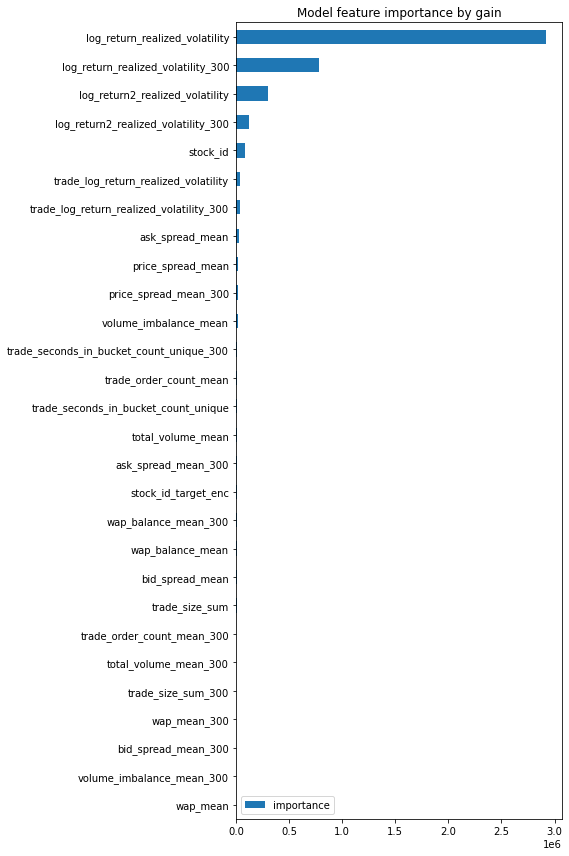

In [43]:
if DO_FEAT_IMP:
    mean_gain_df = calc_mean_importance(gain_importance_list)
    plot_importance(mean_gain_df, title='Model feature importance by gain')
    mean_gain_df = mean_gain_df.reset_index().rename(columns={'index': 'feature_names'})
    mean_gain_df.to_csv('gain_importance_mean.csv', index=False)

In [44]:
scores

0.2344

## 考察

- log_return_realized_volatility(1, 2)  
    推測ボラティリティ(1, 2)は他の特徴量に比べて一桁くらい強い  
    300秒にまとめているが、もう少し細かいレンジで計算する  
    
- stock_id  
    stock_idによって分岐させているのはどうなんだろう...  
    大小関係性はないので、番号毎にわけてるだけ  
    特にいじる意味はない。  
    
- trade_log_return_realized_volatility  
    トレードデータから得られた推測ボラティリティの値
    効果はブックデータの1/100
    
- ask_spread_mean  
    １番目と２番目の***売値***の差(sizeは無視),買値の10倍のgein現象を得ている  
    関係ないと思うけど、引き算以外も試してみる(2乗とか)
    
- price_spred_mean  
    sizeを無視した価格の差  
    売値だけの2/3ほどの効果  
   
- volume_imbalance_mean  
    買いサイズと売りサイズの比率  
    感覚的にもっと効きそうだったがこのくらいの値  
    
- その他  
    その他は一回省略

In [45]:
y_pred = df_test[['row_id']]
X_test = df_test.drop(['time_id', 'row_id'], axis = 1)

In [46]:
target = np.zeros(len(X_test))

#light gbm models
for model in models:
    pred = model.predict(X_test[X_valid.columns], num_iteration=model.best_iteration)
    target += pred / len(models)

In [47]:
target

array([0.00102438, 0.00094753, 0.00094753])

In [48]:
y_pred

,row_id
0,0-4
1,0-32
2,0-34


In [49]:
y_pred = y_pred.assign(target = target)
y_pred.to_csv('submission lightGBM 1.csv',index = False)